# Predict auction price

Try several models and improve predicition accuracy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [2]:
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 18

In [3]:
fn = '../data/cars-for-ml.pkl'
print(fn)
df = pd.read_pickle(fn)

# categories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color', 'energy_label', 'fwd']
print(list(df[cat_columns]))

# numerical
num_columns = list(pd.np.setdiff1d(df.columns, cat_columns + ['price']))
print(list(df[num_columns]))

print(df.index[-1])

../data/cars-for-ml.pkl
['brand', 'model', 'fuel', 'body_type', 'color', 'energy_label', 'fwd']
['age', 'age_at_import', 'days_since_inspection_invalid', 'displacement', 'height', 'length', 'number_of_cylinders', 'number_of_doors', 'number_of_gears', 'number_of_seats', 'odometer', 'power', 'registration_tax', 'sale_price', 'top_speed', 'weight', 'width']
2019-6-9158


In [4]:
models = dict()

- - - - - 
# Model 1: Simple linear fit
Regress age (in days) with price (euro).  
!! Use all data, do not split train and test. !!   
!! Accuracy is based on data that was used for fit. !!

## Prepare input

In [5]:
from sklearn import linear_model

model_name = 'linear regression no cv'

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = df.dropna(subset=['price','age']).price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(3262, 1)
(3262, 1)


## Fit

In [6]:
models[model_name] = dict()

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})

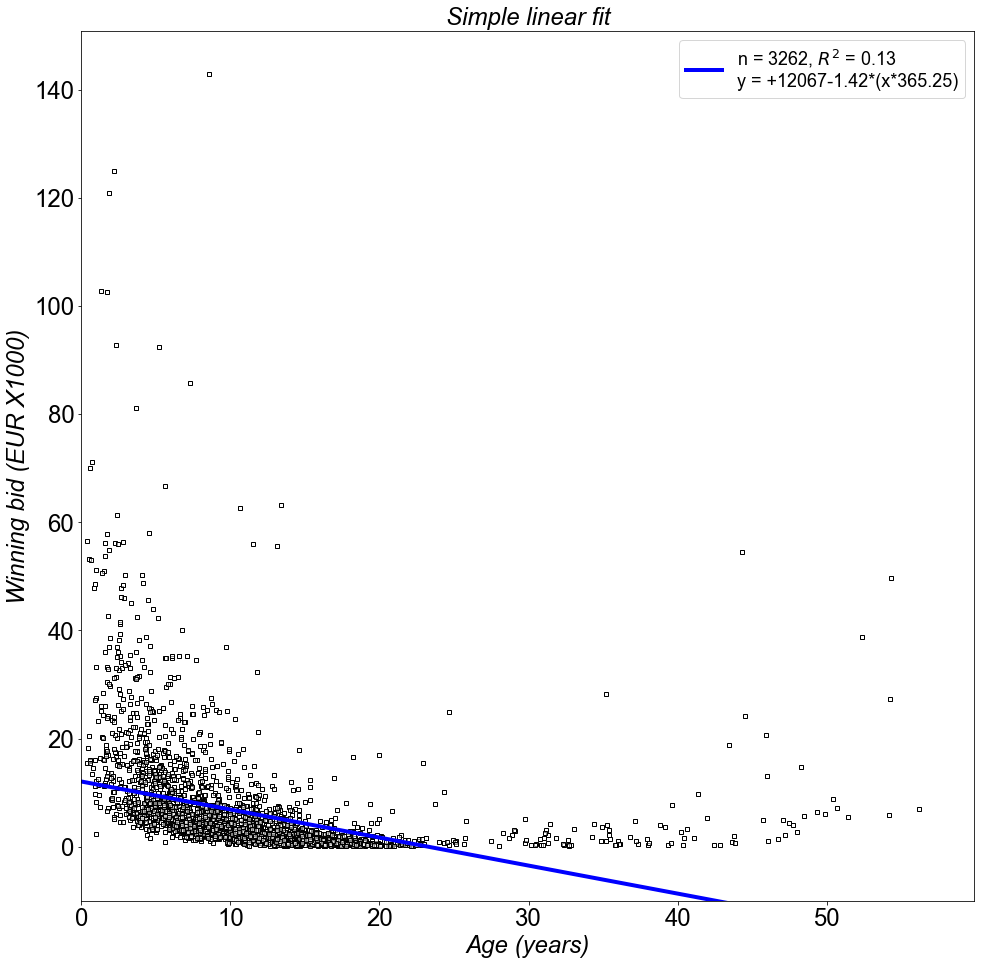

In [7]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
plt.plot(X/365.25, y/1000, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
hdl_fit = plt.plot(prediction_X/365, prediction_y/1000, color='blue', marker=None, linestyle='-', linewidth=4)
plt.legend(hdl_fit, ['n = {}, $R^2$ = {:.2f}\ny = {:+.0f}{:+.2f}*(x*365.25)'.format(
    models[model_name]['n'],
    models[model_name]['R^2'],
    *models[model_name]['betas']
)], loc='upper right')
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR X1000)', style='italic')
plt.title('Simple linear fit', style='italic')
plt.ylim(bottom = -10)
plt.xlim(left = 0)

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

## Model 2: linear but with scaled dependent values (prices)

Prices are log transformed.  
Also use cross validation.

## Prepare input

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price'

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = pd.np.log10(df.dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(3262, 1)
(3262, 1)


## Fit

In [9]:
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2283, 1)
(979, 1)


In [10]:
depr_half_n_days = -(pd.np.log10(2)/models[model_name]['betas'][1])
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('y(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('y(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('y(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

Car depreciates to half its value every
	2534 days (6.9 years).
y(t=   +0) = 9024 euro
y(t=   +2) = 7389 euro
y(t=   +4) = 6051 euro
y(t=   +6) = 4955 euro
y(t=   +8) = 4057 euro
y(t= +6.9) = 4512 euro
y(t=0) / 2 = 4512 euro


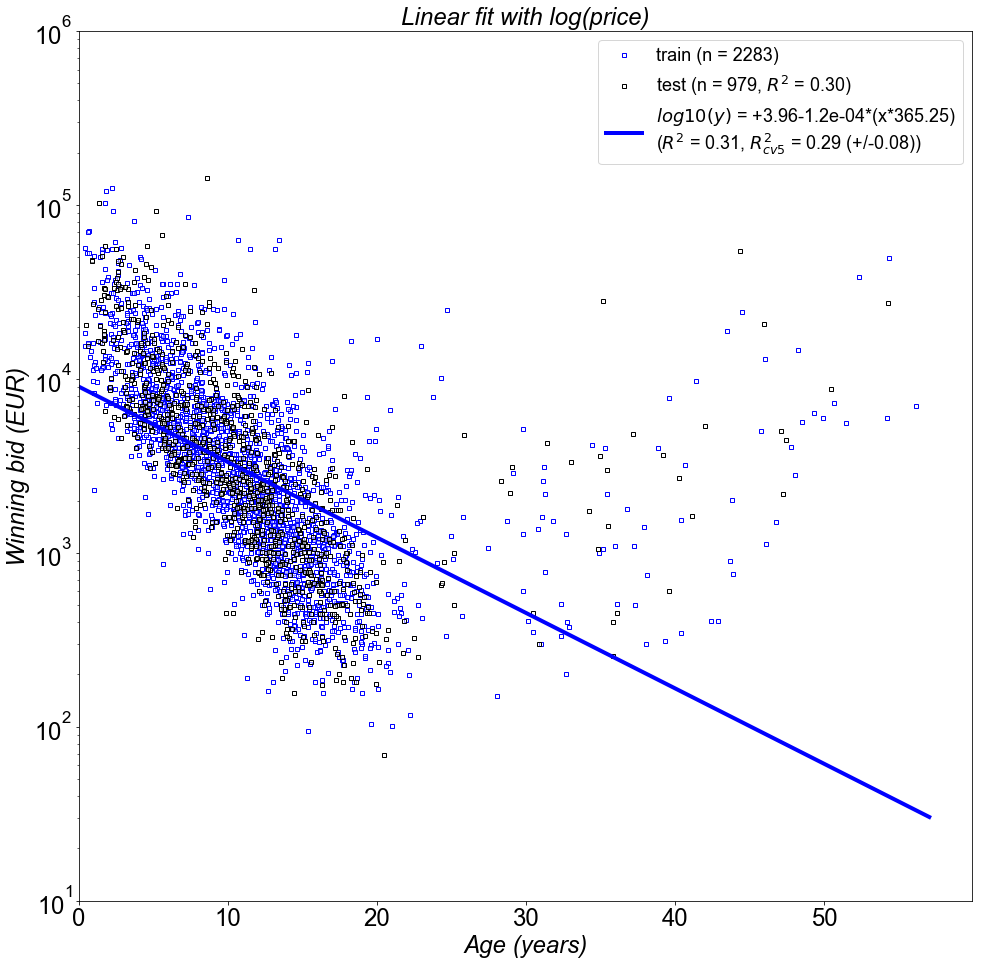

In [11]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
hdl_trn = plt.plot(X_train/365.25, pd.np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, pd.np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, pd.np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       pd.np.mean(models[model_name]['cv R^2']),
                       pd.np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price)', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

## Model 3: scaled price, but only young cars

Same as model 2, but ignore cars older than 25y

## Prepare input

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price young'

is_yng = df.age/365.25 < 25

X = df[is_yng].dropna(subset=['price','age']).age.values.reshape(-1,1)
y = pd.np.log10(df[is_yng].dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(3161, 1)
(3161, 1)


## Fit

In [13]:
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2212, 1)
(949, 1)


In [14]:
depr_half_n_days = -(pd.np.log10(2)/models[model_name]['betas'][1])
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('y(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('y(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('y(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

Car depreciates to half its value every
	1269 days (3.5 years).
y(t=   +0) = 24166 euro
y(t=   +2) = 16217 euro
y(t=   +4) = 10883 euro
y(t=   +6) = 7303 euro
y(t=   +8) = 4901 euro
y(t= +3.5) = 12083 euro
y(t=0) / 2 = 12083 euro


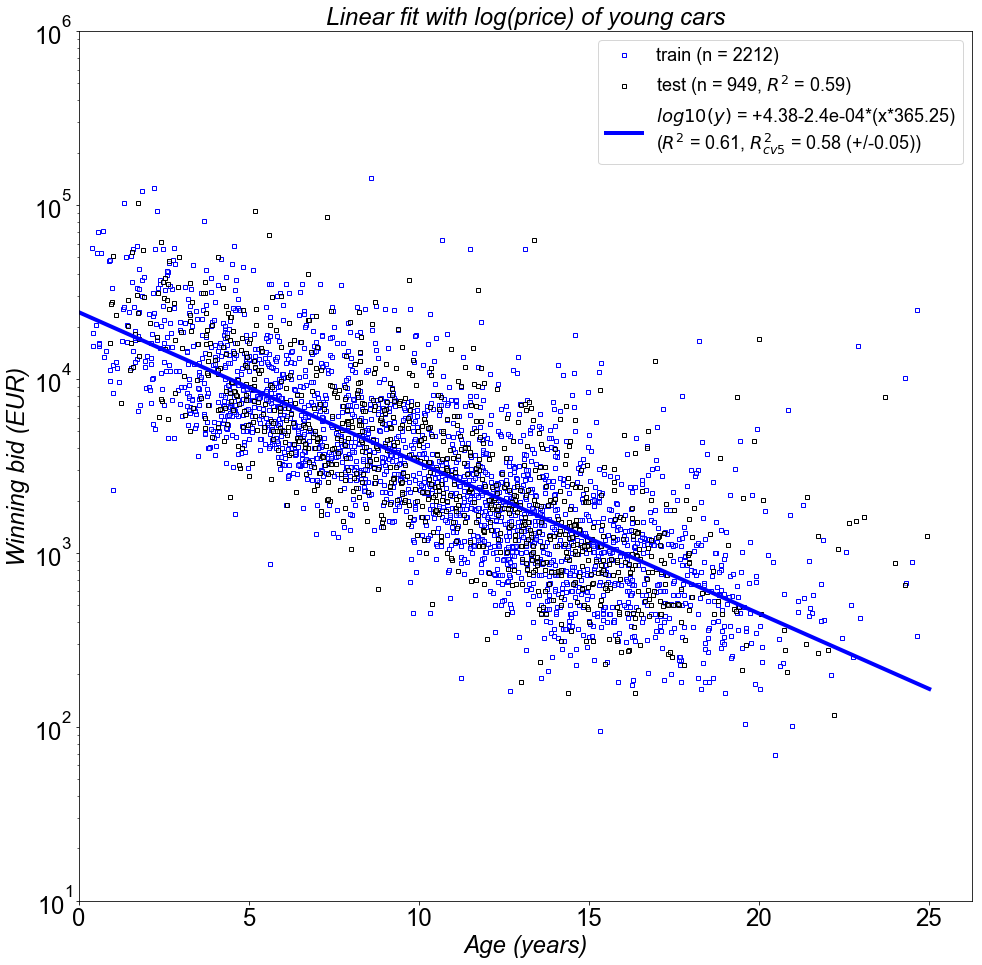

In [15]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
hdl_trn = plt.plot(X_train/365.25, pd.np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, pd.np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, pd.np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       pd.np.mean(models[model_name]['cv R^2']),
                       pd.np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price) of young cars', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

- - - - - 
# Model 4: Multiple linear fit
Regress many (numerical) features with price (euro).  


## Prepare input

In [16]:
model_name = 'MLR'

features = num_columns 
# Can be reduced here

X = df.dropna(subset=['price'] + features).loc[:,features].values.reshape(-1,len(features))
y = pd.np.log10(df.dropna(subset=['price'] + features).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(942, 17)
(942, 1)


## Fit

In [17]:
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(659, 17)
(283, 17)


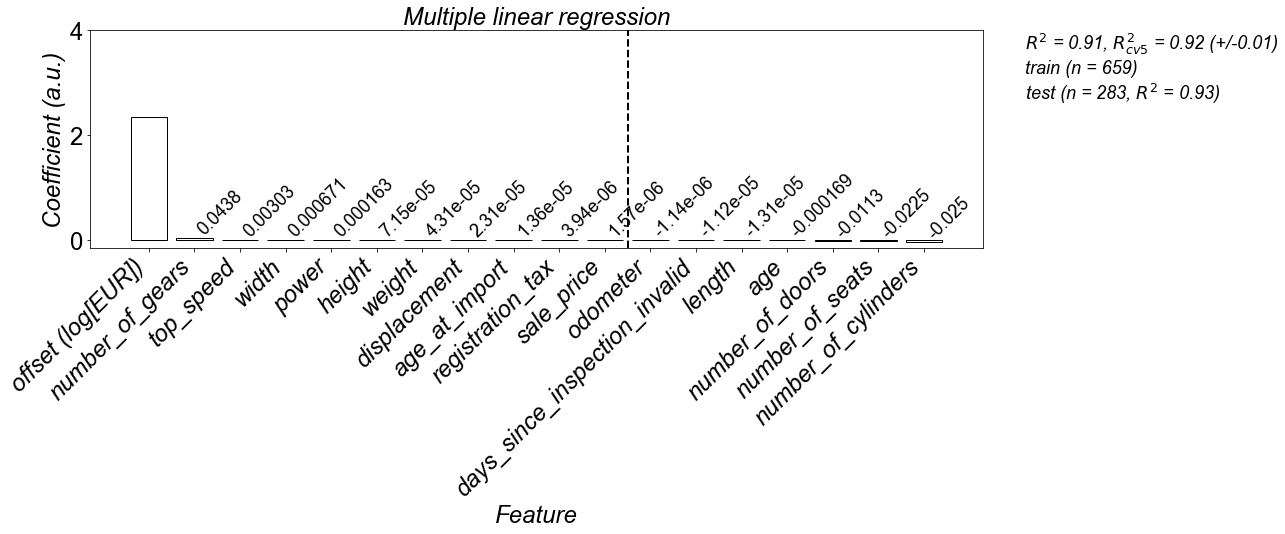

In [18]:
# plot coefficients
plt.figure(figsize=[16,4])

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in pd.np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if pd.np.abs(coef)<1:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(range(0,5,2))

        
x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
yl = plt.gca().get_ylim()
plt.vlines(x_sign_switch-0.5, yl[0], yl[1], linewidth=2, linestyle='--')
plt.gca().set_ylim(yl)
# plt.gca().set_ylim(top=0.01, bottom=-0.01)

# labels        
plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
plt.xlabel('Feature', style='italic')
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    pd.np.mean(models[model_name]['cv R^2']),
    pd.np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

- - - - - 
# Model 5: MLR + imputer

As model 4, but instead of `dropna` us an imputer. Also at this point use a pipeline.

## Prepare input

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model_name = 'MLR impute median'

features = num_columns 
# Can be reduced here

yX = df.loc[:,['price'] + features].dropna(subset=['price'])
X = yX.iloc[:,1:].values.reshape(-1,len(features))
y = pd.np.log10(yX.iloc[:,0].values.reshape(-1,1))
print(X.shape)
print(y.shape)

(3270, 17)
(3270, 1)


## Fit

In [20]:
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    linear_model.LinearRegression()
)
models[model_name].update({'model':pl})

# fit
pl.fit(X,y)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*pl.steps[-1][1].intercept_, *pl.steps[-1][1].coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':pl.score(X,y)})
models[model_name].update({'test R^2':pl.score(X_test,y_test)})
cv_results = cross_val_score(pl, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2289, 17)
(981, 17)


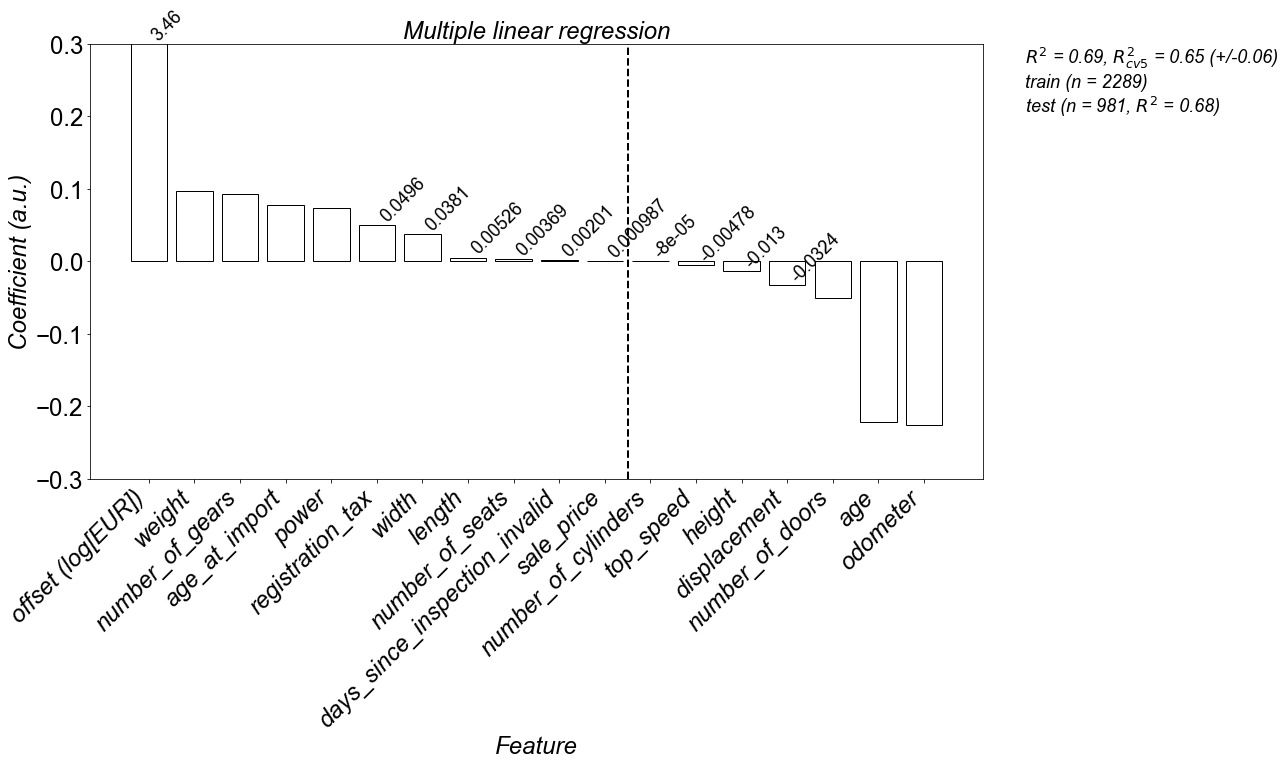

In [21]:
# plot coefficients
plt.figure(figsize=[16,8])

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in pd.np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if pd.np.abs(coef)<0.05:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(pd.np.arange(-0.3,0.4,0.1))
plt.ylim(top=+0.3, bottom=-0.3)
# offset
x_val = x[0]
coef = y[0]
plt.text(x_val, 0.3, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')


x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
yl = plt.gca().get_ylim()
plt.vlines(x_sign_switch-0.5, yl[0], yl[1], linewidth=2, linestyle='--')
plt.gca().set_ylim(yl)
# plt.gca().set_ylim(top=0.01, bottom=-0.01)

# labels        
plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
plt.xlabel('Feature', style='italic')
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    pd.np.mean(models[model_name]['cv R^2']),
    pd.np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

- - - - - 
# Model 6: MLR feature selection

As Model 5, but being a little more smart about the features

## Prepare input

## Fit

Use different scalers for different columns:  
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html  
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
p. 68 book: ML with sklearn & tf

## Model accuracies

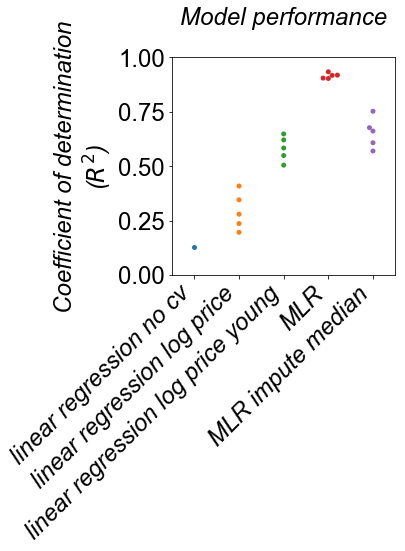

In [22]:
# plot R^2

# counter for x-offset
c=0

# figure
fig = plt.figure(figsize=[4,4])
ax = fig.gca()
xs = ys = [None]

# loop over all models
for name,res in models.items():

    c+=1 # x-offset

    if name == 'linear regression no cv':
        # No cv, so only one value. Make it a list of one for type consistency
        k = 'R^2'
        rsq = [res[k]]
    
    else: 
        k = 'cv R^2'
        rsq = res[k]
        
    # add r-squares and offset to vectors
    ys = pd.np.concatenate([ys,rsq])
    xs = pd.np.concatenate([xs,pd.np.ones_like(rsq) * c])

# actual plotting
sns.swarmplot(x=xs, y=ys, ax=ax)
# prettify
ax.set_xticklabels(models.keys(), rotation=45, va='top', ha='right', style='italic')
ax.set_ylim(bottom=0, top=1)
ax.set_title('Model performance\n', style='italic')
ax.set_ylabel('Coefficient of determination\n($R^2$)', style='italic')


# save
plt.savefig('../results/model-performance.png', bbox_inches='tight', transparent=True)

In [23]:
X = df.loc[:,num_columns].values.reshape(-1,len(num_columns))
y = df.price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

model_name = 'linear regression no cv'
x_ = pd.np.array([ x[0] for x in X ]).reshape(-1,1)
pd.np.nan_to_num(x_, copy=False)
y_pred = models[model_name]['model'].predict(x_)

model_name = 'linear regression log price'
x_ = pd.np.array([ x[0] for x in X ]).reshape(-1,1)
pd.np.nan_to_num(x_, copy=False)
y_pred = models[model_name]['model'].predict(x_)

model_name = 'linear regression log price young'
x_ = pd.np.array([ x[0] for x in X ]).reshape(-1,1)
pd.np.nan_to_num(x_, copy=False)
y_pred = models[model_name]['model'].predict(x_)

model_name = 'MLR'
x_ = X.copy()
# pd.np.nan_to_num(x_, copy=False)
x_[pd.isnull(x_)] = 0
y_pred = models[model_name]['model'].predict(x_)

model_name = 'MLR impute median'
x_ = X.copy()
y_pred = models[model_name]['model'].predict(x_)

(3804, 17)
(3804, 1)


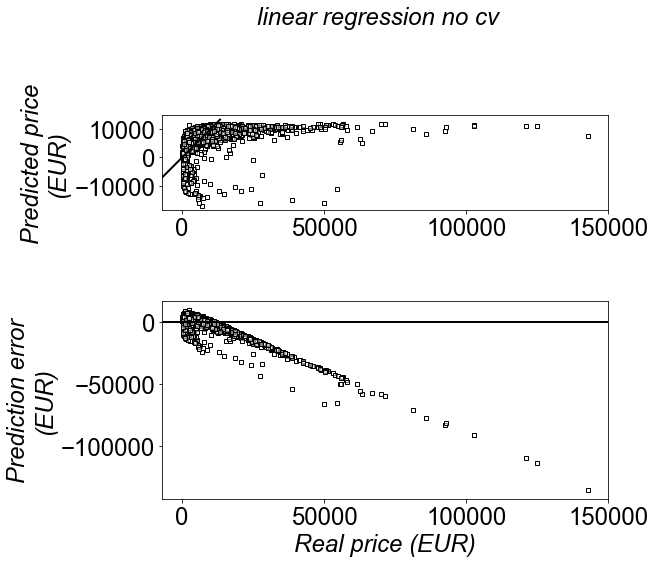

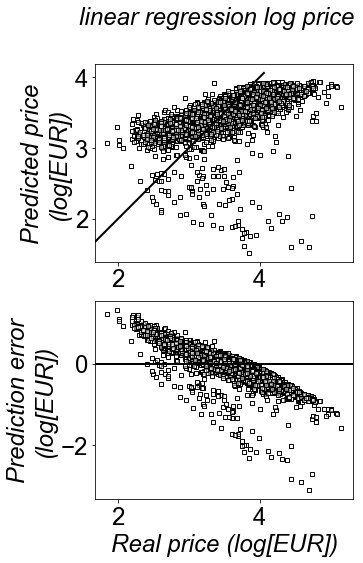

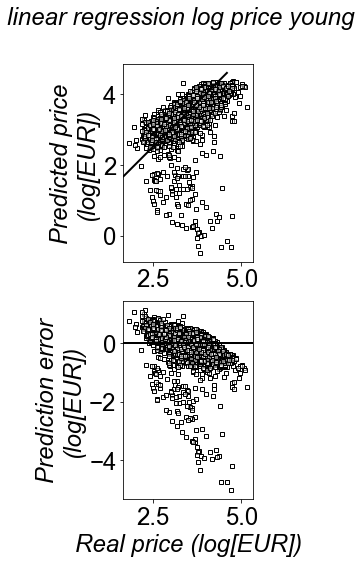

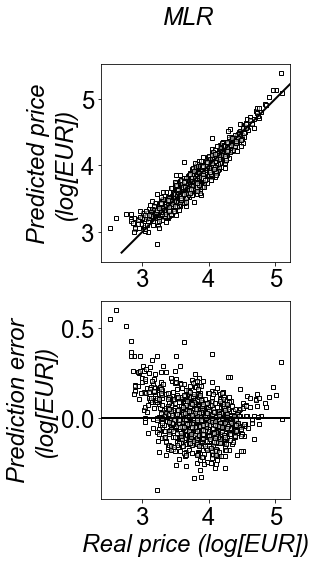

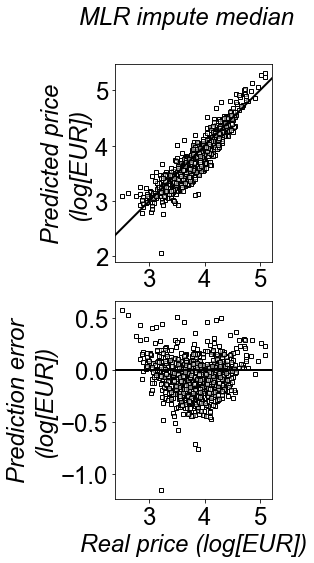

In [24]:
# plot data

# loop over all models
for model_name in models.keys():
    res = models[model_name]
    
    # all original data
    yX = df.loc[:,['price', 'age']].dropna()
    X = yX.iloc[:,1]
    y = yX.iloc[:,0]
    
    features = num_columns.copy()
    
    # model specific adjustments
    if (model_name == 'linear regression log price') or (model_name == 'linear regression log price young'):
        # log price is used
        y = pd.np.log10(y)
        # unit
        unit = '(log[EUR])'
    elif (model_name == 'MLR') or (model_name == 'MLR impute median'):
        yX = df.dropna(subset=['price'] + features).loc[:,['price'] + features]
        X = yX.iloc[:,1:]
        y = pd.np.log10(yX.iloc[:,0])
        unit = '(log[EUR])'
    elif (model_name == 'MLR selected features'):
        yX = df.dropna(subset=['price'] + features).loc[:,['price'] + features]

        # feature adjustments
        yX.drop(columns='power', inplace=True)
        yX.rename(columns={'power2':'power'}, inplace=True)
#         yX['usage'] = (yX.odometer / yX.age)
#         yX.drop(columns=['odometer'], inplace=True)
        
        X = yX.iloc[:,1:]
        y = pd.np.log10(yX.iloc[:,0])
        unit = '(log[EUR])'
    else:
        unit = '(EUR)'
    
    if X.ndim != 1:
        n_feat = X.shape[1]
    else:
        n_feat = 1
        
    # needed for .predict
    X = pd.np.array(X).reshape(-1,n_feat)
    y = pd.np.array(y).reshape(-1,1)
    
    # predict all data
    y_pred = res['model'].predict(X)

    # actual plotting
    fig,axs = plt.subplots(nrows=2, ncols=1, figsize=[8,8])
    
    # data
    axs[0].plot(y, y_pred, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4,)
    # error
    axs[1].plot(y, y_pred-y, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4,)
    
    # axis equal for top
    axs[0].set_aspect(1)
    # store limits
    yl = axs[0].get_ylim()
    xl_top = axs[0].get_xlim()
    xl_bot = axs[1].get_xlim()
    xl = [pd.np.max([xl_top[0], xl_bot[0]]), pd.np.min([xl_top[1], xl_bot[1]])]
    # plot unity line and 0 error
    unity_line = [pd.np.max([xl[0], yl[0]]), pd.np.min([xl[1], yl[1]])]
    axs[0].plot(unity_line, unity_line, '-k', linewidth=2)
    axs[1].plot(xl, [0, 0], '-k', linewidth=2)
    # reset limits
    axs[0].set_xlim(xl)
    axs[1].set_xlim(xl)

    # make equal size panels
    # Note: sharex did not work
    bb=axs[0].get_position(False)
    rect_top = bb.bounds
    bb=axs[1].get_position(False)
    rect_bot = bb.bounds
    rect = list(rect_bot)
    rect[0] = rect_top[0]
    rect[2] = rect_top[2]
    axs[1].set_position(rect)
    
    # labeling
    fig.suptitle(model_name, style='italic')
    axs[1].set_xlabel('Real price ' + unit, style='italic')
    axs[0].set_ylabel('Predicted price\n' + unit, style='italic')
    axs[1].set_ylabel('Prediction error\n' + unit, style='italic')
    
    # save
    fig.savefig('../results/{}-accuracy.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)